# Guidelines

This notebook is a template of what could be explored. You can follow it or explore and experiment additional things.

Use the notebook to add your comments, figures, .... You can remove and reorganize it as you wish. The goal is for you to make a nice report. The important points are to: 
- understand what you will write
- explain the experimental results
- the code should be clean and well documented
- when copy many times the same code, take the time to create a function instead. 

# Autoencoders

An autoencoder (**AE**) is a special type of neural network that is trained to copy its input to its output. For an image of handwritten digits, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes this latent representation go recover the original image. Of course, in the middle you have a compression of the information, and the task should not be trivial. 

An autoencoder learns to compress the data while minimizing the reconstruction error. This is an example of unsupervised learning. 
Autoencoder can be used to learn representation (the by product of the encoder), and to detect anomalies.  



An autoencoder consists in two blocks: 
- the encoder projects the input in a latent space of "reduced" dimension (in comparison with the input). 
- the decoder maps some latent representation back in the input space. 

Basically, if you consider an input $\mathbf{x}$ : 
$$\mathbf{z} = encoder(\mathbf{x})$$
$$\mathbf{\tilde{x}} = decoder(\mathbf{z})$$

The goal is to train the AE. The goal is to minimize the reconstruction error. This error can be defined as the mean square error  : 
$$\min||\mathbf{\tilde{x}}-\mathbf{x}||^2$$ 

For this lab session, you can work with the Fashion MNIST dataset, or the MNIST dataset. It is maybe better to use MNIST (I prefer). 


**Representation Learning: and semi-supervised training** Assume we have many images without annotations (no lables or classes assigned by a human). We can train an AE on this dataset. Then if a small subset of these images are annotated, we can train a classifier by reusing the encoder part of the AE. The encoder can learn (unsupervised) to represent data from many images, and the (supervised) classifier can leverage the small set of annotated data with the pre-trained encoder. 

**Anomalie detection:** Assume we have a large dataset. For example, the dataset contains only images of faces. Then we want to detect anomalies: images that do not represent faces like we have in our dataset. The AE is a simple yet efficient tool to achieve anomalie detection. The reconstruction error should be high if it is an anomalie and low otherwise. 

Before experimenting these kind of applications. Let us build and explore AEs. 


# Initialization of session  

imports and datasets. You need the dataset. 

In [2]:
# Load the dataset
import _pickle as cPickle
import  gzip
import numpy as np

import math

import matplotlib
import matplotlib.pyplot as plt 

import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
th.manual_seed(1) # set the seed 
import pickle


In [3]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/DPLEARNING
filename='mnist.pkl.gz' 
fp = gzip.open(filename,'rb')



Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DPLEARNING


In [4]:
# or fashion-mnist.pk.gz if you prefer but 
# take the code of the corresponding lab
T = 50000 # the number of images for training
V = 10000 # the number of images for validation
u = pickle._Unpickler( fp )
u.encoding = 'latin1'
train, valid, test  = u.load() 
allXtrain , allYtrain = train
print(allXtrain.shape)
# Below we ensure that the values of pixels are between 0 and 1.  
maxv   = allXtrain[0].max()
Xtrain = allXtrain[:T]/maxv
Ytrain = allYtrain[:T]
Xvalid = valid[0][:V]/maxv
Yvalid = valid[1][:V]

Xtrain = th.from_numpy(Xtrain)
Ytrain = th.from_numpy(Ytrain)
Xvalid = th.from_numpy(Xvalid)
Yvalid = th.from_numpy(Yvalid)

print(Xtrain.shape[0] , " Training images" )
print(Xvalid.shape[0] , " Valid.   images" )
print(Xtrain.shape , " Training images" )
print(Ytrain.shape , " Valid.   images" )

(50000, 784)
50000  Training images
10000  Valid.   images
torch.Size([50000, 784])  Training images
torch.Size([50000])  Valid.   images


min :  tensor(0.) max :  tensor(1.)


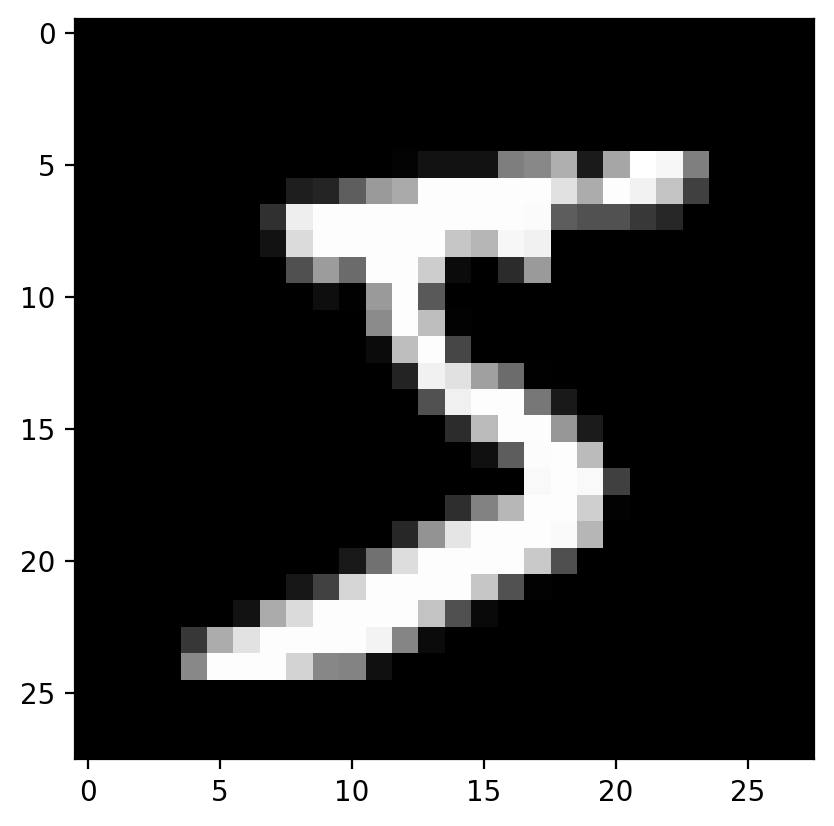

min :  tensor(0.) max :  tensor(1.)


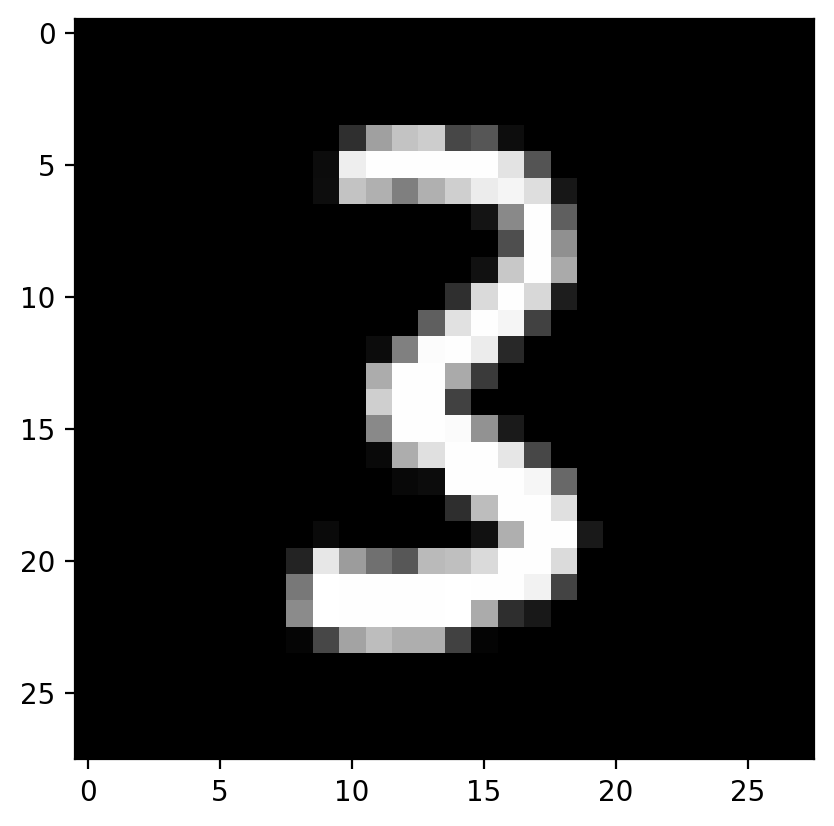

In [5]:
%matplotlib inline
%config InlineBackend.figure_formats=['retina']
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

im = Xtrain[0]
plt.show()
plt.imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray)
print("min : ", im.min(),"max : ",im.max())

im = Xvalid[0]
plt.show()
plt.imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray)
print("min : ", im.min(),"max : ",im.max())


In [ ]:
print(Ytrain)

tensor([5, 0, 4,  ..., 8, 4, 8])


# First try : Simple Auto-encoder 

The basic idea is to have a linear transformation followed by a non-linearity for both the encoder and decoder. 
For the output activation, we can use the sigmoid, since we know that the images are in greyscale, and the pixel values are between $0$ and $1$. 

The only hyperparameter we have is the dimension of the latent space: $h < 784$ (784 is the dimension of the input space).


**TODO**: The idea is to define a class where we will have two
"blocks": the encoder and the decoder.  The encoder is a simple Linear layer followed by a non-linearity (like Relu for instance). The decoder is also a Linear Layer but followed by a sigmoid. The important hyper-parameter here is $h$. It should be a parameter given to the constructor.

Write a class for the autoencoder and test it on some images as sanity-check (of course if it is not trained, the results wont be meaningful). 


In [6]:
class SimpleAE(nn.Module):
    # TODO : 
    def __init__(self,h):
        super(SimpleAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(784, h), nn.Sigmoid(),
                                     nn.Linear(h, 2), nn.Tanh())
        
        self.decoder = nn.Sequential(nn.Linear(2, h), nn.Sigmoid(),
                                     nn.Linear(h, 784), nn.Sigmoid())

    def forward(self,x) :
        return  self.decoder(self.encoder(x))

    def Encoder(self,x) :
        return  self.encoder(x)

In [ ]:
'''class SimpleAE(nn.Module):
    # TODO : 
    def __init__(self,h):
        super(SimpleAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(784, h), nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Linear(h, 784), nn.Sigmoid())

    def forward(self,x) :
        return  self.decoder(self.encoder(x))

    def hidden_layer(self,x) :
        return  self.encoder(x)'''

'class SimpleAE(nn.Module):\n    # TODO : \n    def __init__(self,h):\n        super(SimpleAE, self).__init__()\n        self.encoder = nn.Sequential(nn.Linear(784, h), nn.ReLU())\n        \n        self.decoder = nn.Sequential(nn.Linear(h, 784), nn.Sigmoid())\n\n    def forward(self,x) :\n        return  self.decoder(self.encoder(x))\n\n    def hidden_layer(self,x) :\n        return  self.encoder(x)'

In [9]:
class ComplexAE(nn.Module):
    # TODO : 
    def __init__(self):
        super(SimpleAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 512), nn.ReLU(),
                                     nn.Linear(512, 128), nn.ReLU(),
                                     nn.Linear(128, 64), nn.ReLU(),
                                     nn.Linear(64, 2))
        
        self.decoder = nn.Sequential(nn.Linear(2, 64), nn.ReLU(),
                                     nn.Linear(64, 128), nn.ReLU(),
                                     nn.Linear(128, 512), nn.ReLU(),
                                     nn.Linear(512, 784),nn.Sigmoid())

    def forward(self,x) :
        return  self.decoder(self.encoder(x))

    def hidden_layer(self,x) :
        return  self.encoder(x)

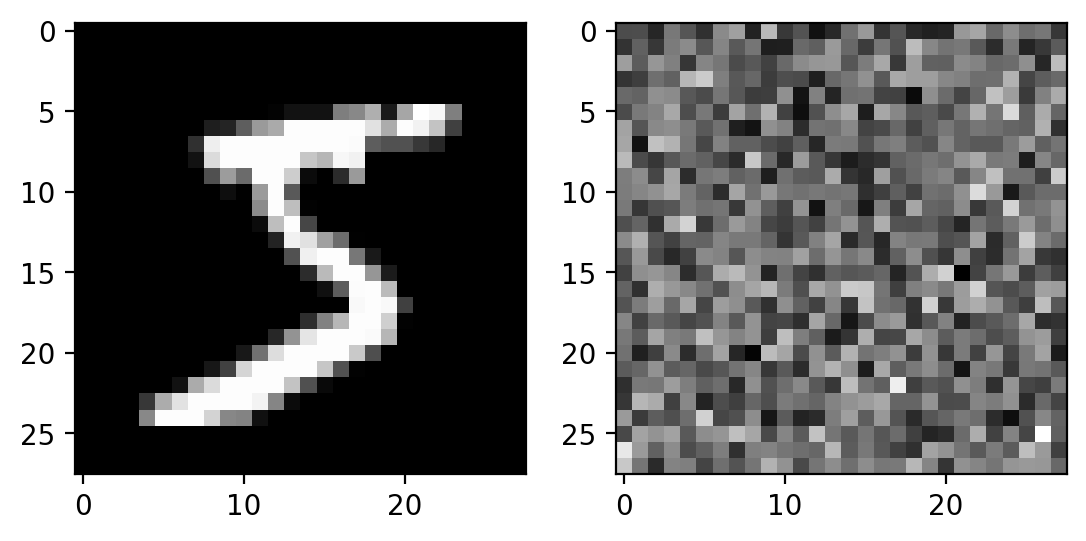

In [8]:
# Testing the class
h = 10
module_SimpleAE = SimpleAE(h)
output = module_SimpleAE.forward(Xtrain[0])

im = output.detach().numpy()
figs, axs = plt.subplots(1,2)
axs[0].imshow(Xtrain[0].reshape(28,28), matplotlib.pyplot.cm.gray)
axs[1].imshow(im.reshape(28,28), matplotlib.pyplot.cm.gray)


output = module_SimpleAE.Encoder(Xtrain[0])


In [10]:
import time
'''
def loss_fn(x_in, x_out) : 
  loss = (x_in - x_out)**2
  loss_ = loss.sum()

  return loss_'''

loss_fn = nn.MSELoss()

def train_AE(model, epochs=30,verbose=False,lr=0.001, batch_size=200, plot = False):
    inicio = time.time()
    
    optimizer=th.optim.Adam(model.parameters(),lr=lr)
    ### Mini-batching and shuffle 
    Ntrain = Xtrain.shape[0]
    Nvalid = Xvalid.shape[0]
    idx = np.arange(Ntrain)
    nbatch = int(Ntrain/batch_size)
    ### store results
    train_losses,valid_losses = [],[]
    ########################
    # Training #############
    ########################
    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0

        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            images_original = Xtrain[ids]
            optimizer.zero_grad()
            images_reconst = model(images_original)
            loss = loss_fn(images_reconst,images_original)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities   
        with th.no_grad():
            model.eval()
            images_original = Xvalid
            images_reconst = model(images_original)
            valid_loss = loss_fn(images_reconst,images_original)
            valid_losses.append(100*valid_loss/Nvalid)
        model.train()
        train_losses.append(100*running_loss/Ntrain)

        if verbose: 
            print("Epoch: {}\t".format(e+1),
                      "train Loss: {:.5f}.. ".format(train_losses[-1]),
                      "valid Loss: {:.5f}.. ".format(valid_losses[-1]))
    
    final = time.time()

    print("Run Time: {}\t".format(final-inicio))

    #########
    # plot ##
    #########
    if plot :
      fig, ax = plt.subplots(1,2,figsize = (9, 3),tight_layout = True)
      ax[0].plot(train_losses,'k')
      ax[0].set_ylabel(r" Train losses ", size=15)
      ax[0].set_xlabel(r" Epoch ", size=15)
      ax[0].grid('minor')
      ax[0].set_ylim(bottom=0)

      ax[1].plot(valid_losses,'k')
      ax[1].set_ylim(bottom=0)
      ax[1].set_ylabel(r" Valid losses ", size=15)
      ax[1].set_xlabel(r" Epoch ", size=15)
      ax[1].grid('minor')
      ax[1].set_ylim(bottom=0)

      plt.show()

**TODO** Write a function for training an autoencoder. The function should consider:
- one model (the autoencoder)
- with some training data
- for some epochs
- with Adam and a tuneable learning rate.

Epoch: 1	 train Loss: 0.04777..  valid Loss: 0.00068.. 
Epoch: 2	 train Loss: 0.03414..  valid Loss: 0.00067.. 
Epoch: 3	 train Loss: 0.03388..  valid Loss: 0.00067.. 
Epoch: 4	 train Loss: 0.03380..  valid Loss: 0.00067.. 
Epoch: 5	 train Loss: 0.03377..  valid Loss: 0.00067.. 
Epoch: 6	 train Loss: 0.03375..  valid Loss: 0.00067.. 
Epoch: 7	 train Loss: 0.03373..  valid Loss: 0.00067.. 
Epoch: 8	 train Loss: 0.03372..  valid Loss: 0.00067.. 
Epoch: 9	 train Loss: 0.03314..  valid Loss: 0.00063.. 
Epoch: 10	 train Loss: 0.03124..  valid Loss: 0.00061.. 
Epoch: 11	 train Loss: 0.03064..  valid Loss: 0.00060.. 
Epoch: 12	 train Loss: 0.03024..  valid Loss: 0.00059.. 
Epoch: 13	 train Loss: 0.02993..  valid Loss: 0.00059.. 
Epoch: 14	 train Loss: 0.02972..  valid Loss: 0.00059.. 
Epoch: 15	 train Loss: 0.02959..  valid Loss: 0.00058.. 
Epoch: 16	 train Loss: 0.02951..  valid Loss: 0.00058.. 
Epoch: 17	 train Loss: 0.02945..  valid Loss: 0.00058.. 
Epoch: 18	 train Loss: 0.02939..  valid 

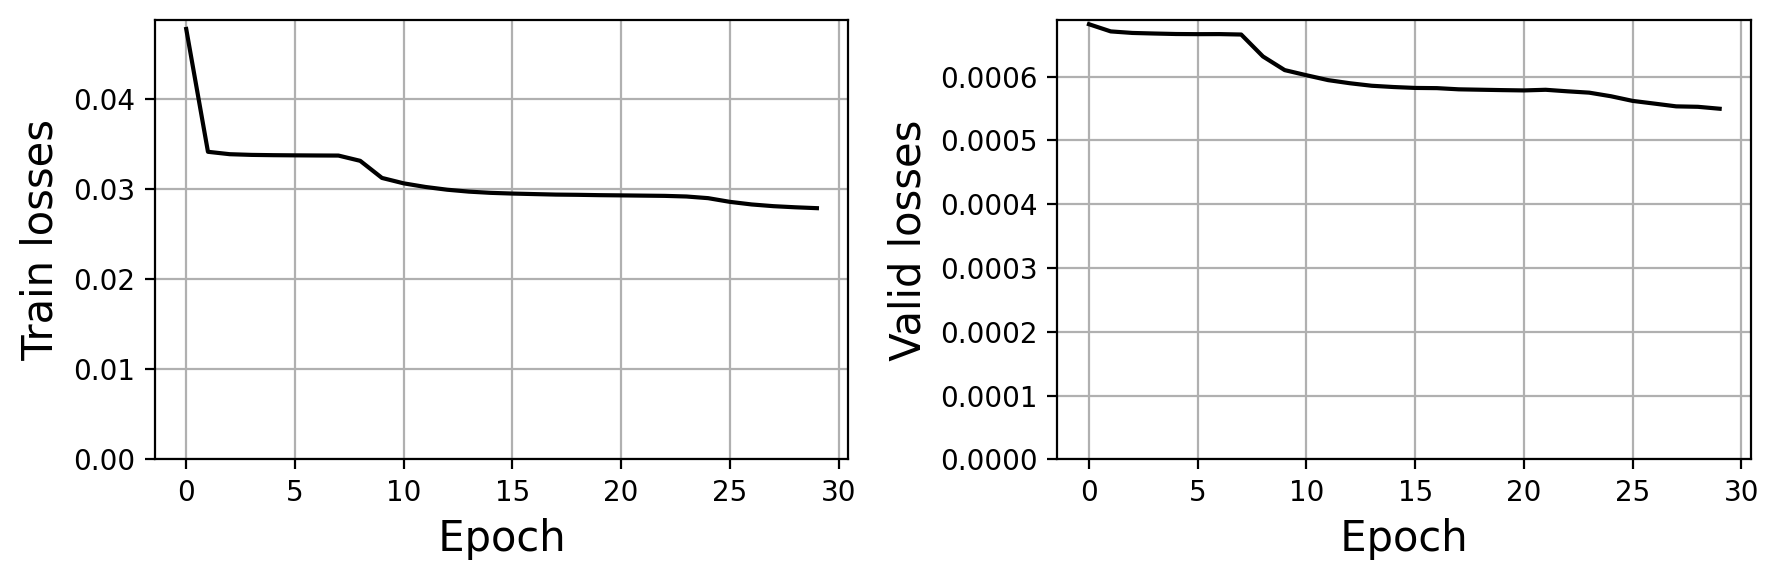

In [23]:
hidden_dim = 2

#Training

model = SimpleAE(hidden_dim)
train_AE(model, epochs = 30, lr = 0.01, plot = True, verbose = True)

X_result = model(Xtrain)


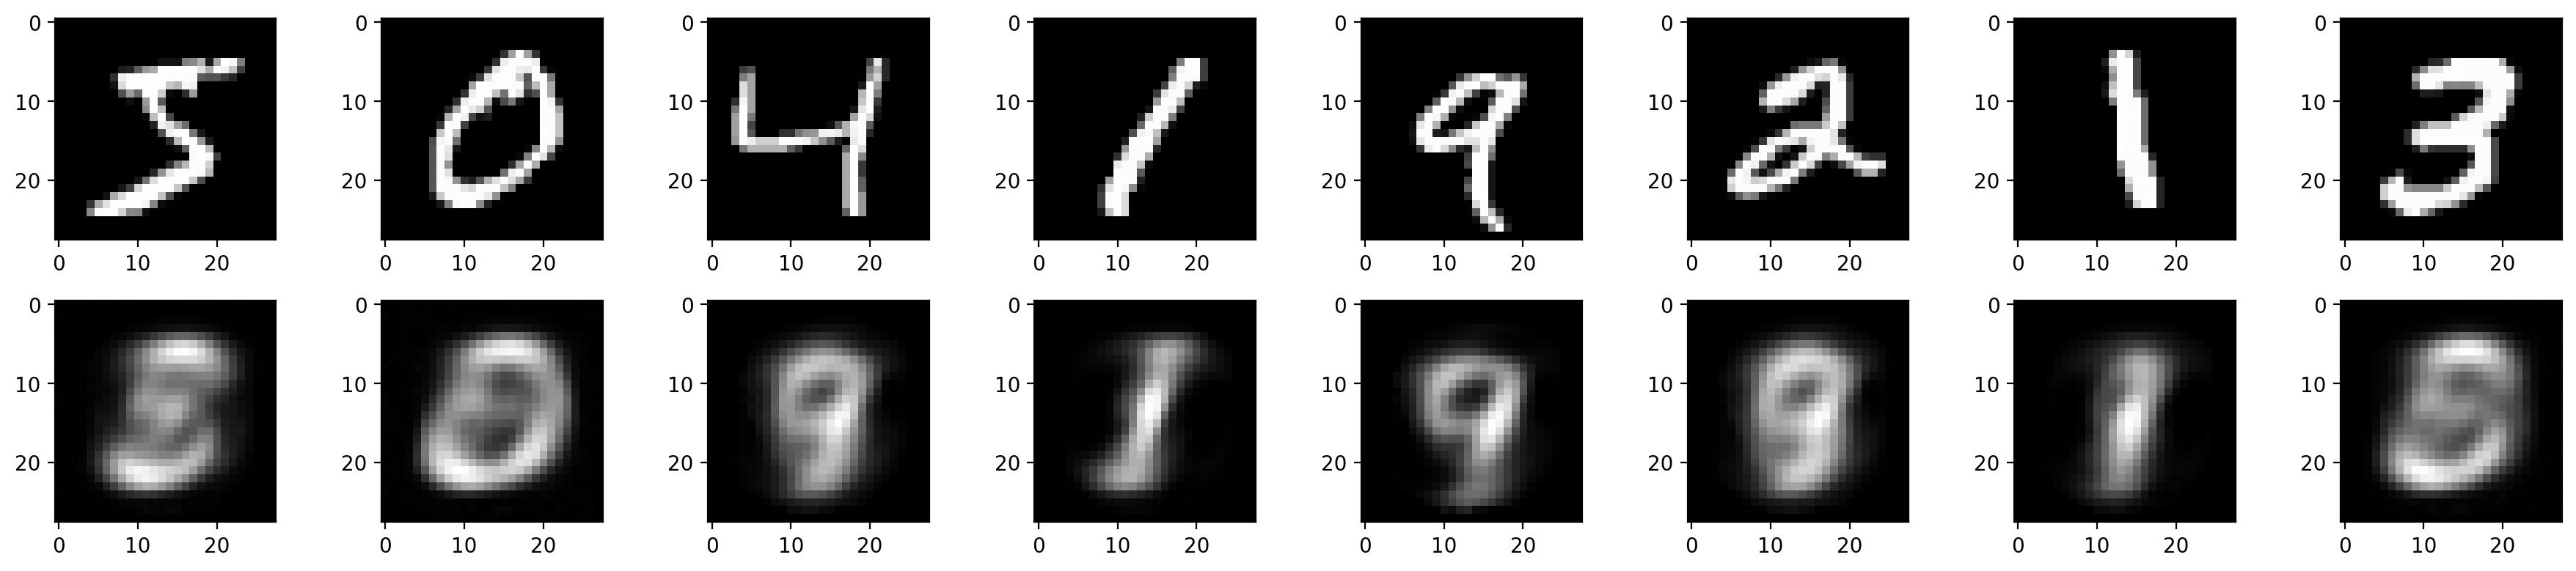

In [24]:
def comparison_images(N,Xtrain,X_result,inicio = 0) : 
  fig, ax = plt.subplots(2,N,figsize = (18, 4),tight_layout = True)

  for n in range(N) :

    im1 = Xtrain[inicio+n].detach().numpy() 
    ax[0,n].imshow(im1.reshape(28,28) , matplotlib.pyplot.cm.gray)

    im2 = X_result[inicio+n].detach().numpy() 
    ax[1,n].imshow(im2.reshape(28,28) , matplotlib.pyplot.cm.gray)

  plt.show()

N = 8
comparison_images(N,Xtrain,X_result)


**TODO**:
- Then use this function to train the AE and look at some reconstructions to see the results. Start with a hidden dimension of $2$.
- With a hidden representation of dimension $h=2$. You can visualize the projections performed by the encoder of the images. Plot the hidden representation of each image according to the class. You can use the function scatter of matplotlib. You can also write a function that takes a model and a dataset (images and labels) to plot the projection (you will use it many times). 
* Don't forget to try different values of the learning rate **for all the experiments now and after !**  

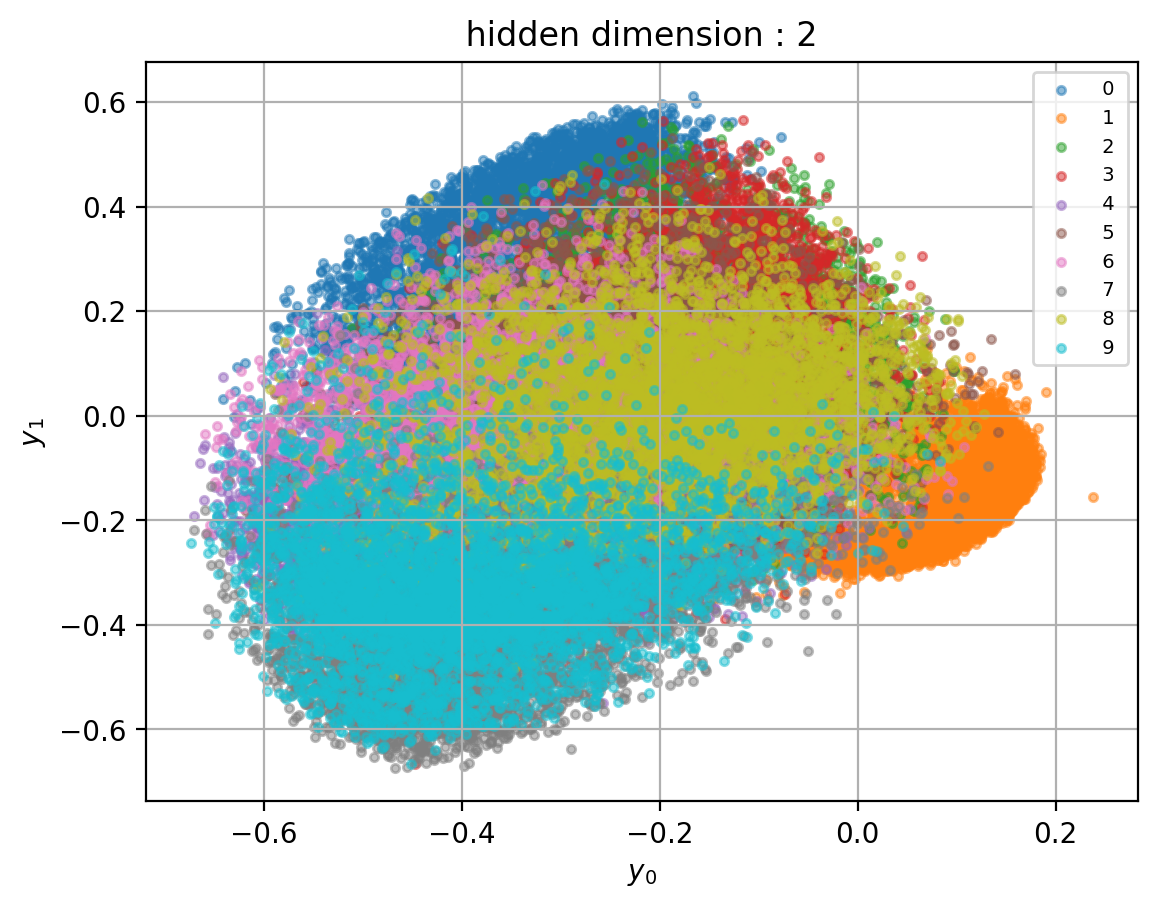

In [25]:
def projection(model,images, labels):
  
  proj_imag = model.Encoder(images)

  plt.figure()
  for i in range(10):

    y = proj_imag[labels == i].detach().numpy()
    plt.scatter(y[:,0] ,y[:,1] , label= " {} ".format(i), s = 9, alpha = .5)
    plt.xlabel('$y_0$')
    plt.ylabel('$y_1$')
    plt.legend(fontsize = 7)
    plt.grid('minor')
    plt.title(" hidden dimension : {} ".format(h))
  
  plt.show()

h = hidden_dim
projection(model,Xtrain, Ytrain )

## Increase the dimension of the latent representation 


**TODO**
Try different sizes : 10 and 50. For a qualitative evaluation, you can take some randomly selected images: 

In [26]:
imids = np.random.choice(Xtrain.shape[0],10)

hidden_dim = [10,50, 100]
for h in hidden_dim :
  print('h : ',h)
  model = SimpleAE(h)
  train_AE(model, lr = 0.01, plot = True)
  im_reconst = model(Xtrain[imids])
  projection(model,Xtrain,Ytrain)
  comparison_images(10,Xtrain[imids],im_reconst) 


Output hidden; open in https://colab.research.google.com to view.

And for these images plot (imshow) the original images and their reconstructions, syde by side. You can also evaluate your autoencoder with the reconstruction error measured on the validation set. 

# Anomaly detection

Autoencoders can learn to represent the data in a latent representation space and to reconstruct the data from this compressed representation. One possible application of AE is Anomaly detection. The method is simple: 
- if you encode and decode an image similar to the training data, the reconstruction loss should be low, while 
- if you do the same with an image that differs from the training set, the loss should be higher. 



## Easy case 
As a preliminary experiment, we can compute the following histograms:  
- the loss on the training data (take all the training images, for each of them compute the loss, then compute the histogram) 
- the loss on the training where the images are transposed. 


**TODO**: code a function that: 
- compute these two histograms
- plots these two histograms on the same figure (plt.hist is your friend)


In [ ]:
hidden_dim = 10
model = SimpleAE(hidden_dim)
train_AE(model, verbose= True, plot = True)
#Training



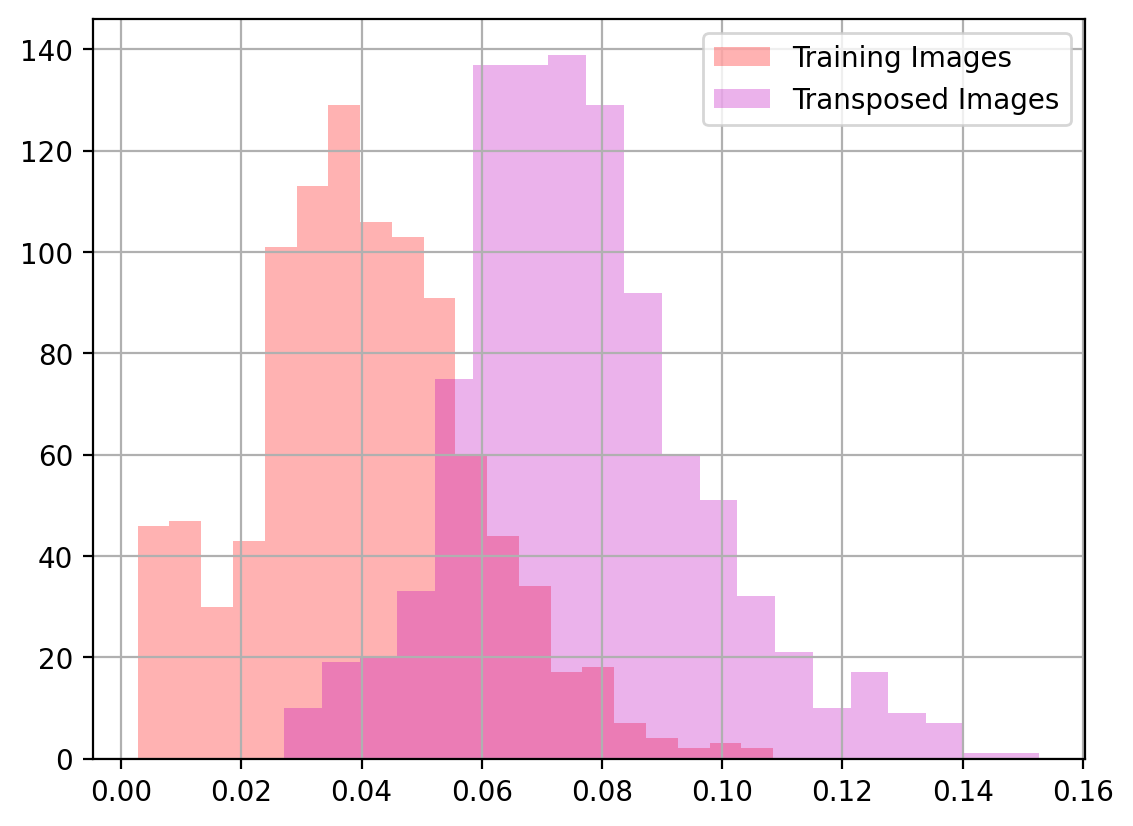

In [27]:
def loss_comparison(model, NumImages = 50000, hist = True, Numbin = 20, Seed = False, Valid = False) :
  
  if Seed :
    np.random.seed(5)

  imids = np.random.choice(Xtrain.shape[0],NumImages)
  images = Xtrain[imids]
  images_trans = th.transpose(images.view(-1,28,28), 1,2).flatten(start_dim = 1)
  reconst_imag = model(images)
  reconst_trans = model(images_trans) 

  Loss1, Loss2 = [], []

  for i in range(NumImages):
    Loss1.append(loss_fn(reconst_imag[i], images[i]).detach().numpy())
    Loss2.append(loss_fn(reconst_trans[i], images_trans[i]).detach().numpy())

  if hist :
    fig, ax = plt.subplots()
    ax.hist(Loss1, bins = Numbin, alpha = 0.3, color = 'r', label = 'Training Images')
    ax.hist(Loss2, bins = Numbin, alpha = 0.3, color = 'm', label = 'Transposed Images')

  if Valid:
    images = Xvalid
    images_trans = th.transpose(images.view(-1,28,28), 1,2).flatten(start_dim = 1)
    reconst_imag = model(images)
    reconst_trans = model(images_trans) 

    Loss1_V, Loss2_V = [], []

    for i in range(Xvalid.shape[0]):
      Loss1_V.append(loss_fn(reconst_imag[i], images[i]).detach().numpy())
      Loss2_V.append(loss_fn(reconst_trans[i], images_trans[i]).detach().numpy())

    if hist :
      ax.hist(Loss1_V, bins = Numbin, alpha = 0.3, color = 'k', label = 'Validation Images')
      ax.hist(Loss2_V, bins = Numbin, alpha = 0.3, color = 'b', label = 'Transposed Images')

  ax.legend()
  ax.grid( 'minor')
  plt.show()

  return Loss1, Loss2

he = loss_comparison(model, NumImages=1000, Numbin = 20, Seed = True)


**TODO**: Compare these results when $h$ increases (like before from 2 to 50 and even 100). 

In [ ]:

hidden_dim = [10,20,50]
for h in hidden_dim :
  print('h : ',h)
  model = SimpleAE(h)
  train_AE(model, plot = True)
  projection(model,Xtrain,Ytrain)
  loss_comparison(model, NumImages=1000, Numbin = 20, Seed = True)

Output hidden; open in https://colab.research.google.com to view.

**TODO**: 
Compare the histograms of the reconstruction loss of 
- the train
- the validation

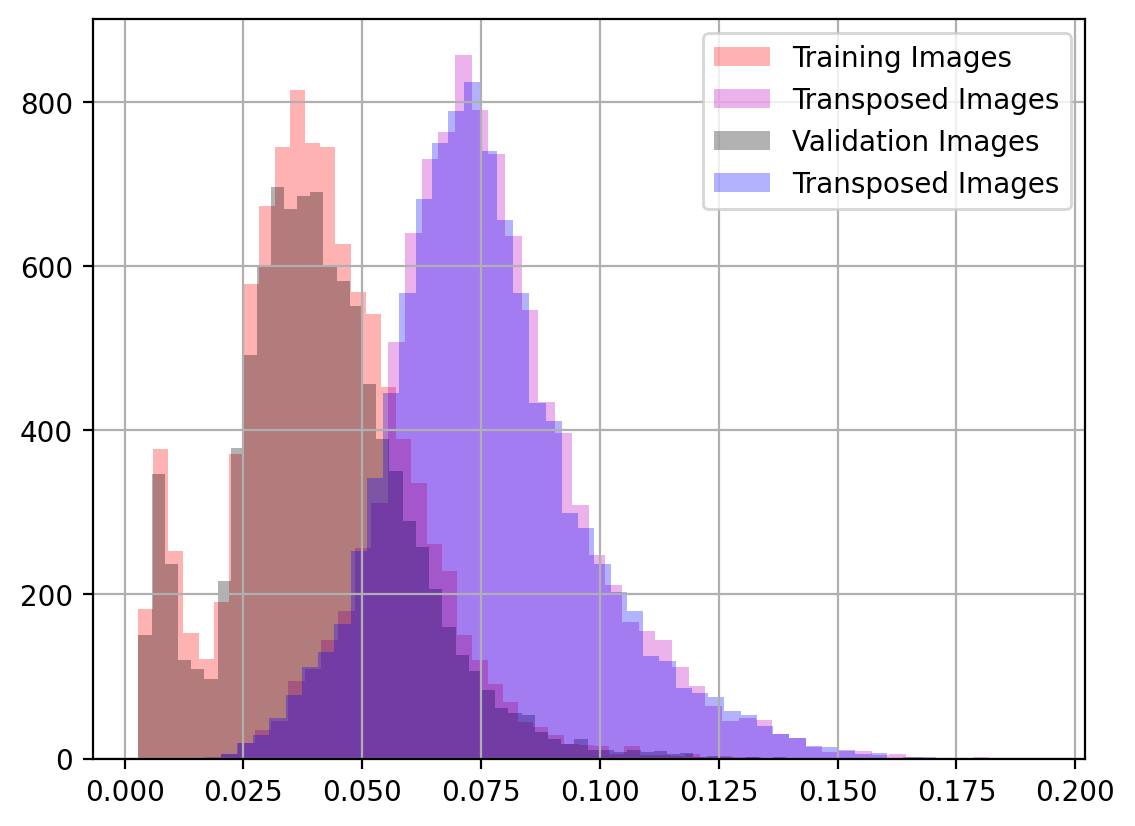

In [28]:

he = loss_comparison(model, NumImages=Xvalid.shape[0], Numbin = 50, Seed = True, Valid = True)

# Semi supervised Training

In semi-supervised training, we will split the training set in two parts: 

In [ ]:
supervised_part = 5000
XunsupTrain = Xtrain # To train the auto-encoder
XsupTrain = Xtrain[:supervised_part] # To train the classifier


The first idea is two fold: 
- Representation learning:  first learn the AE on its training part *XunsupTrain*. Take for instance an efficient setup (like $h=50$, a good learning rate and number of epochs).   
- Then use  the encoder part of the model as the first layer of a classifier. Train the classifier on  *XsupTrain*. 

In [29]:
class Classifier(nn.Module) :
    def __init__(self, model, h) :
        super(Classifier, self).__init__()
        self.model = model
        self.decoder = nn.Sequential(nn.Linear(2, 10), nn.LogSoftmax(1))

    def forward(self,x) :
        return  self.decoder(self.model.Encoder(x))

In [30]:
import time

def train_Classifier(model, xtrain, ytrain, epochs=30,verbose=False,lr=0.01, batch_size=100, plot = True):
    inicio = time.time()
    loss_fn = nn.NLLLoss()
    optimizer=th.optim.Adam(model.parameters(),lr=lr)
    ### Mini-batching and shuffle 
    Ntrain = xtrain.shape[0]
    Nvalid = Xvalid.shape[0]
    idx = np.arange(Ntrain)
    nbatch = int(Ntrain/batch_size)
    ### store results
    train_losses,valid_losses, valid_accuracies=[],[],[]
    ########################
    # Training #############
    ########################
    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0
        totaln = 0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            images = xtrain[ids]
            labels = ytrain[ids]
            totaln += labels.shape[0] # the number of samples
            optimizer.zero_grad()
            logprobs=model(images)
            loss=loss_fn(logprobs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities
        accuracy=0
        valid_loss = 0        
        with th.no_grad():
            model.eval()
            images = Xvalid
            labels = Yvalid
            logprobs=model(images)
            valid_loss=loss_fn(logprobs,labels)
            top_p,top_class=logprobs.topk(1)
            accuracy=(top_class.T == labels).sum().float()
            valid_losses.append(100*valid_loss/Nvalid)
            valid_accuracies.append(accuracy.item()*100.0/Nvalid)
        model.train()
        train_losses.append(100*running_loss/Ntrain)

        if verbose: 
            print("Epoch: {}\t".format(e+1),
                      "train Loss: {:.5f}.. ".format(train_losses[-1]),
                      "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
                      "valid Accuracy: {:.3f}".format(valid_accuracies[-1]))  
    print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " 
          , np.fromiter(valid_accuracies, dtype=float).argmax(), " / ",epochs )
    
    final = time.time()

    print("Run Time: {}\t".format(final-inicio))

    #########
    # plot ##
    #########
    if plot :
      fig, ax = plt.subplots(1,3,figsize = (9, 3),tight_layout = True)
      ax[0].plot(train_losses,'r')
      ax[0].set_ylabel(r" Train losses ", size=15)
      ax[0].set_xlabel(r" Epoch ", size=15)
      ax[0].grid('minor')
      ax[0].set_ylim(bottom=0)

      ax[1].plot(valid_losses,'r')
      ax[1].set_ylim(bottom=0)
      ax[1].set_ylabel(r" Valid losses ", size=15)
      ax[1].set_xlabel(r" Epoch ", size=15)
      ax[1].grid('minor')
      ax[1].set_ylim(bottom=0)

      ax[2].plot(valid_accuracies,'r')
      ax[2].set_ylim(bottom=0)
      ax[2].set_ylabel(r" Valid accuracies ", size=15)
      ax[2].set_xlabel(r" Epoch ", size=15)
      ax[2].grid('minor')
      ax[2].set_ylim(bottom=0)

      plt.show()

In [40]:
def SemiSupervised(h = 100, supervised_part = 5000, train_unsup = True) :
  model_UnSup = SimpleAE(h)
  if train_unsup :
    train_AE(model_UnSup, epochs=30, verbose=False, lr=0.01, batch_size=200, plot = True)
  XsupTrain = Xtrain[:supervised_part]
  YsupTrain = Ytrain[:supervised_part]

  classifier = Classifier(model_UnSup,h)
  print("{} data used for supervised learning".format(supervised_part))
  train_Classifier(classifier,  XsupTrain, YsupTrain, epochs=100,verbose=False,lr=0.01, batch_size=100, plot = True)

Run Time: 58.69677186012268	


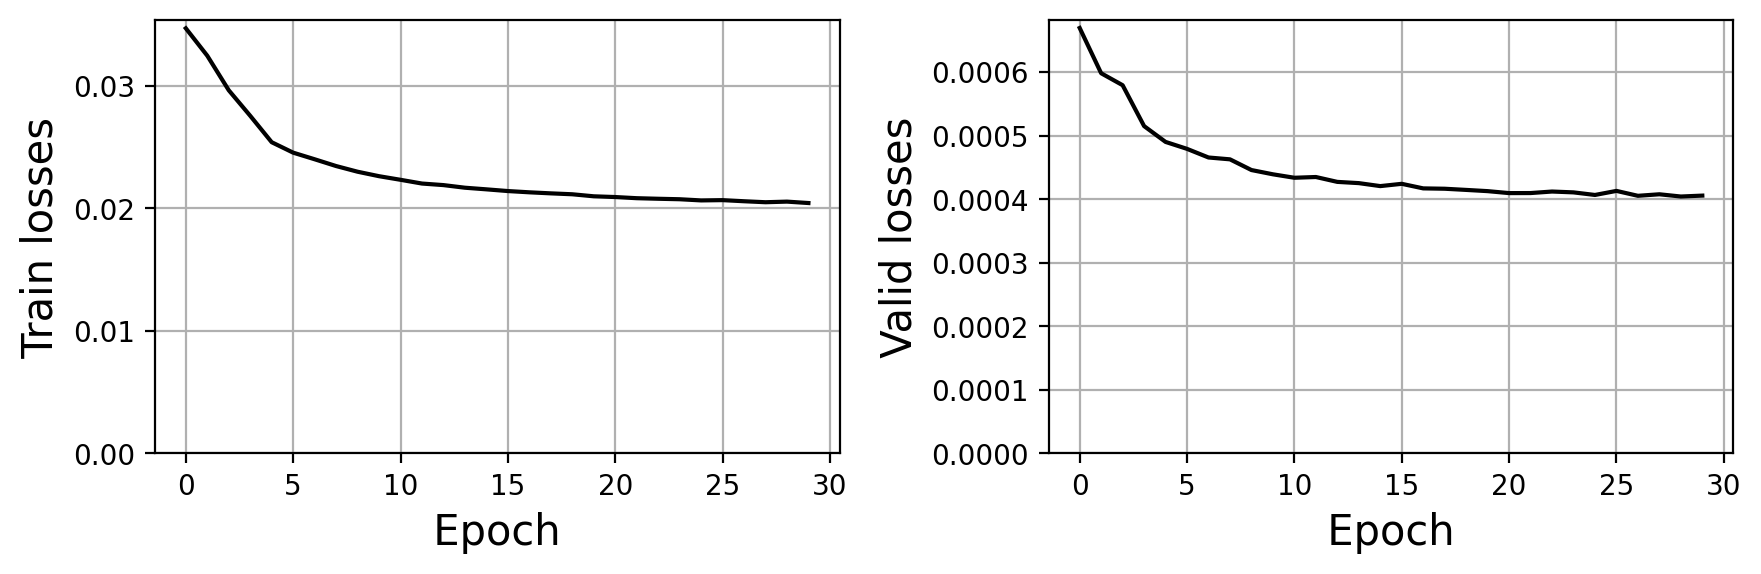

---------- Best : 89.200  at epoch  69  /  100
Run Time: 19.35783362388611	


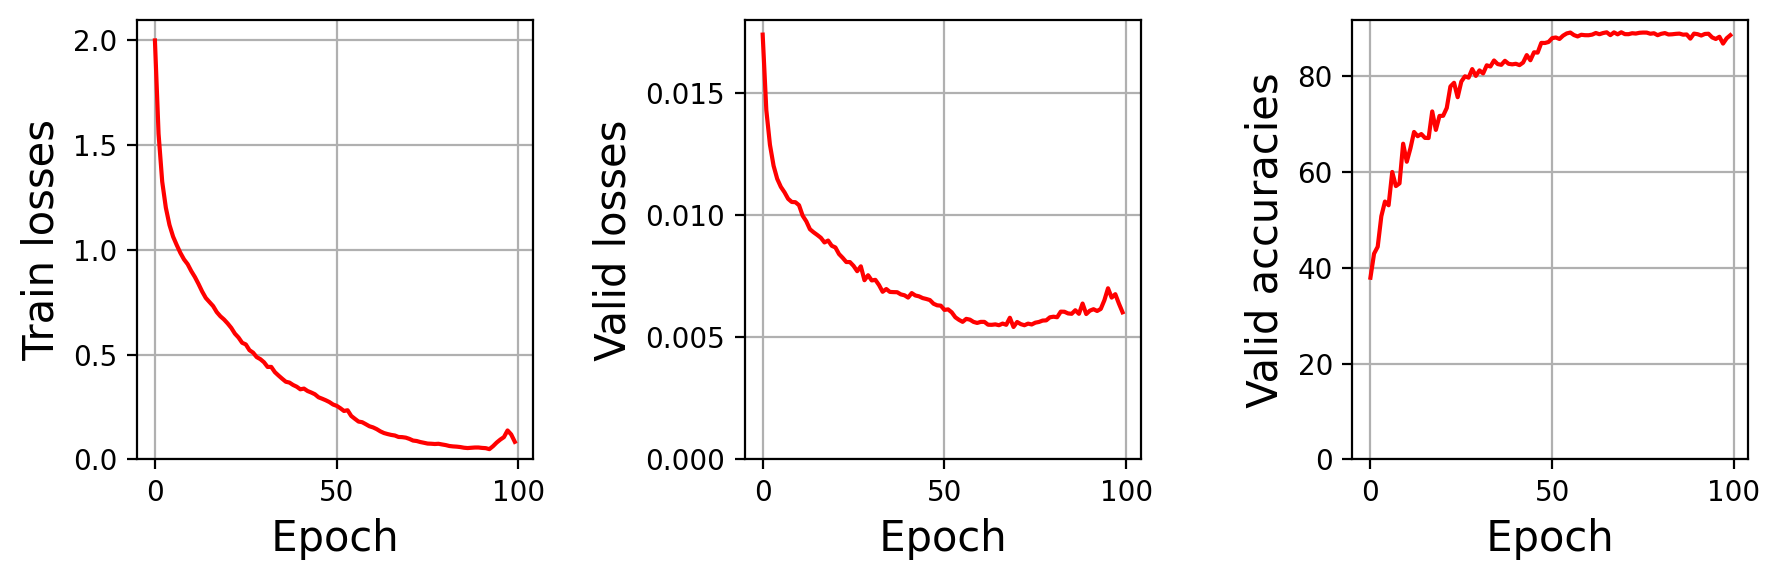

In [36]:
SemiSupervised()

Try different value of *supervised_part* : 100, 500, 1000, 2000, 5000, 10000, ... . The criterion of evaluation is the accuracy of the classfier on the validation set.

100 data used for supervised learning
---------- Best : 37.140  at epoch  33  /  100
Run Time: 5.2257773876190186	


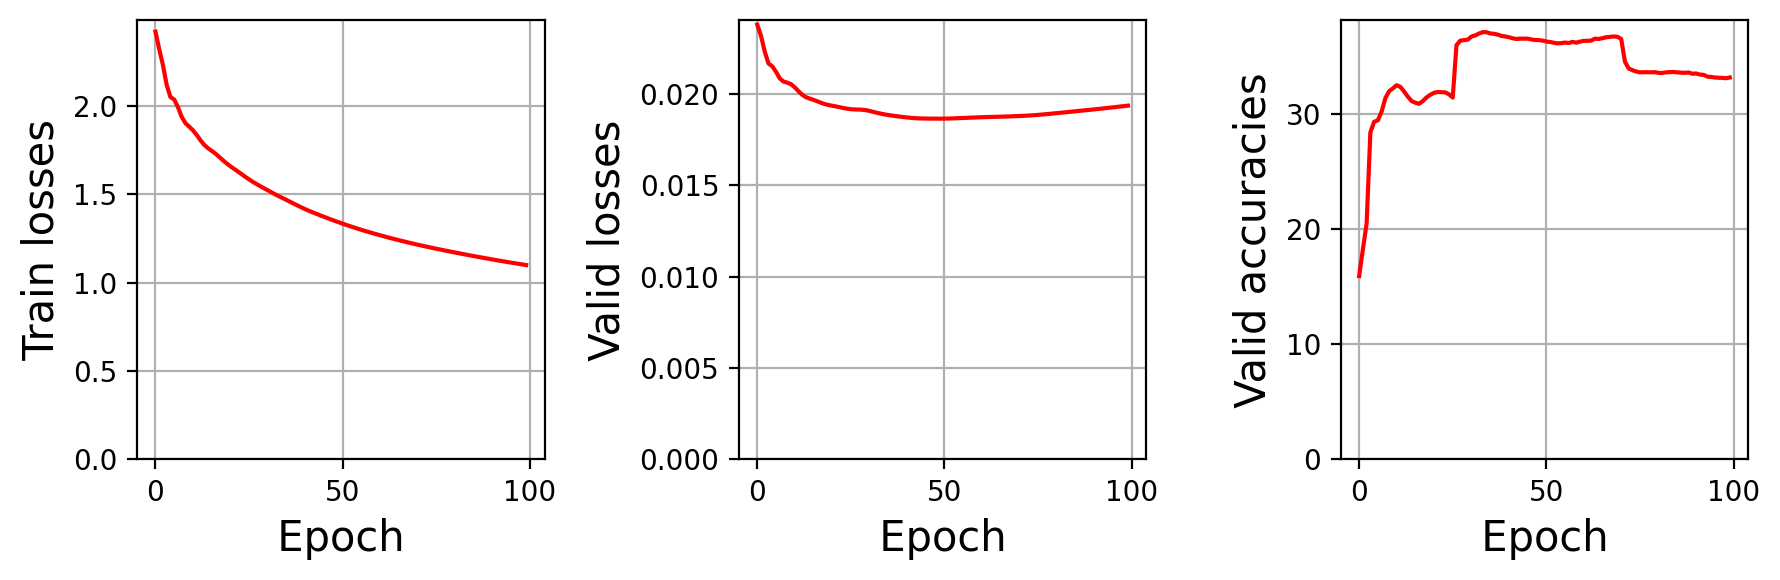

500 data used for supervised learning
---------- Best : 50.950  at epoch  90  /  100
Run Time: 4.944246292114258	


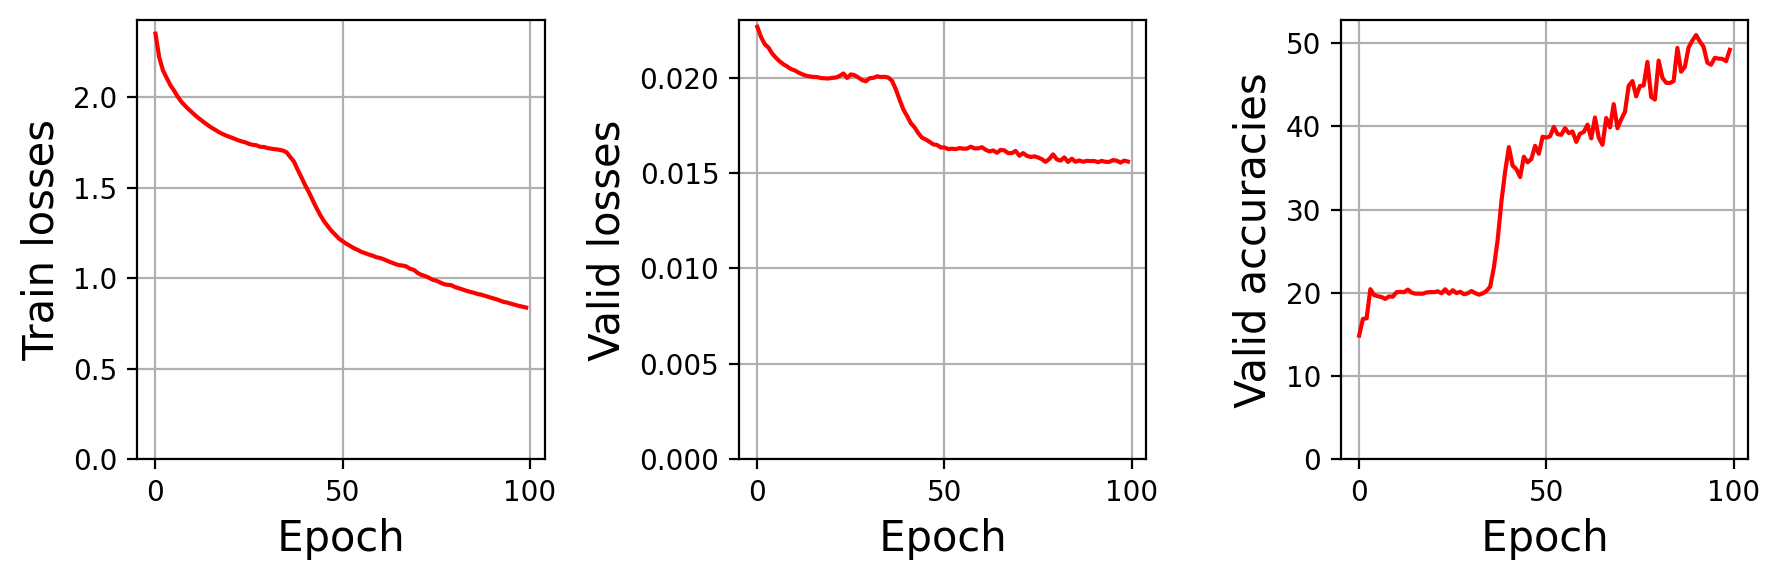

1000 data used for supervised learning
---------- Best : 60.620  at epoch  98  /  100
Run Time: 7.20302677154541	


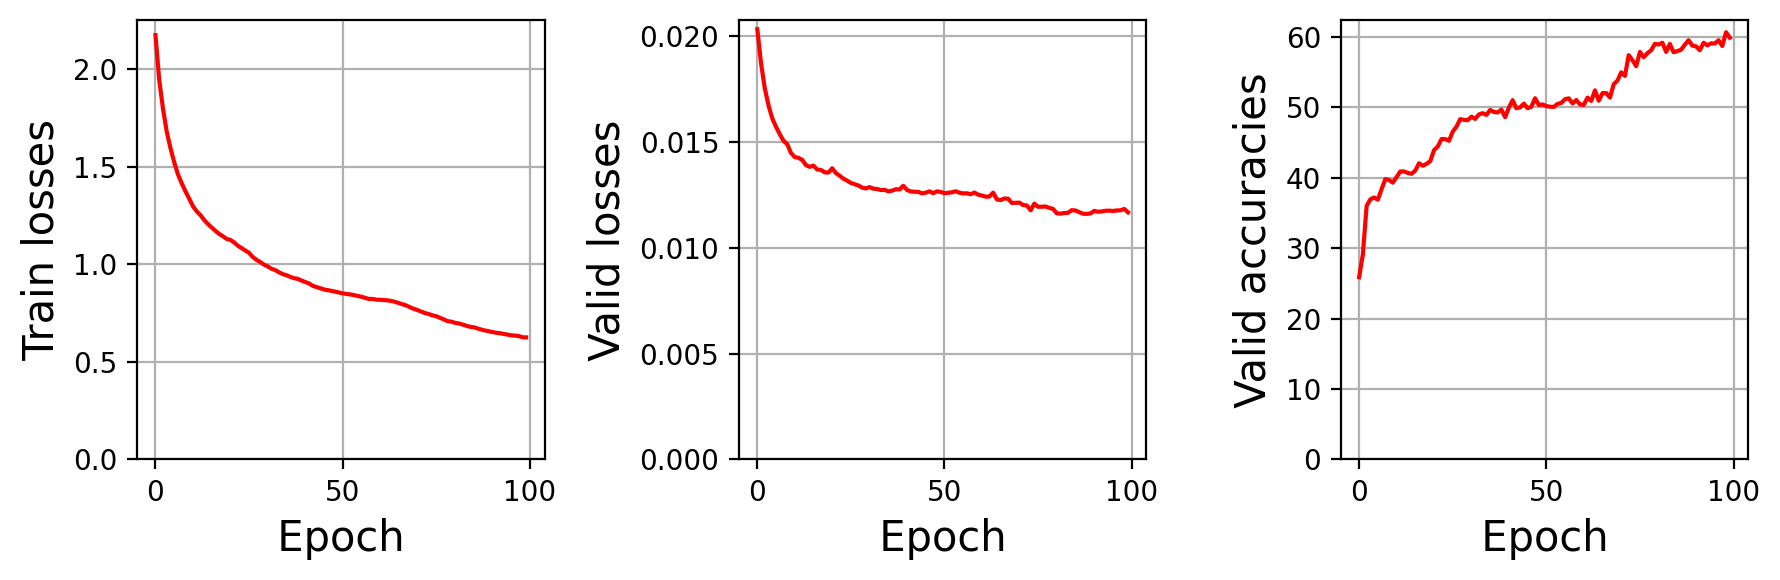

2000 data used for supervised learning
---------- Best : 65.190  at epoch  99  /  100
Run Time: 8.96723198890686	


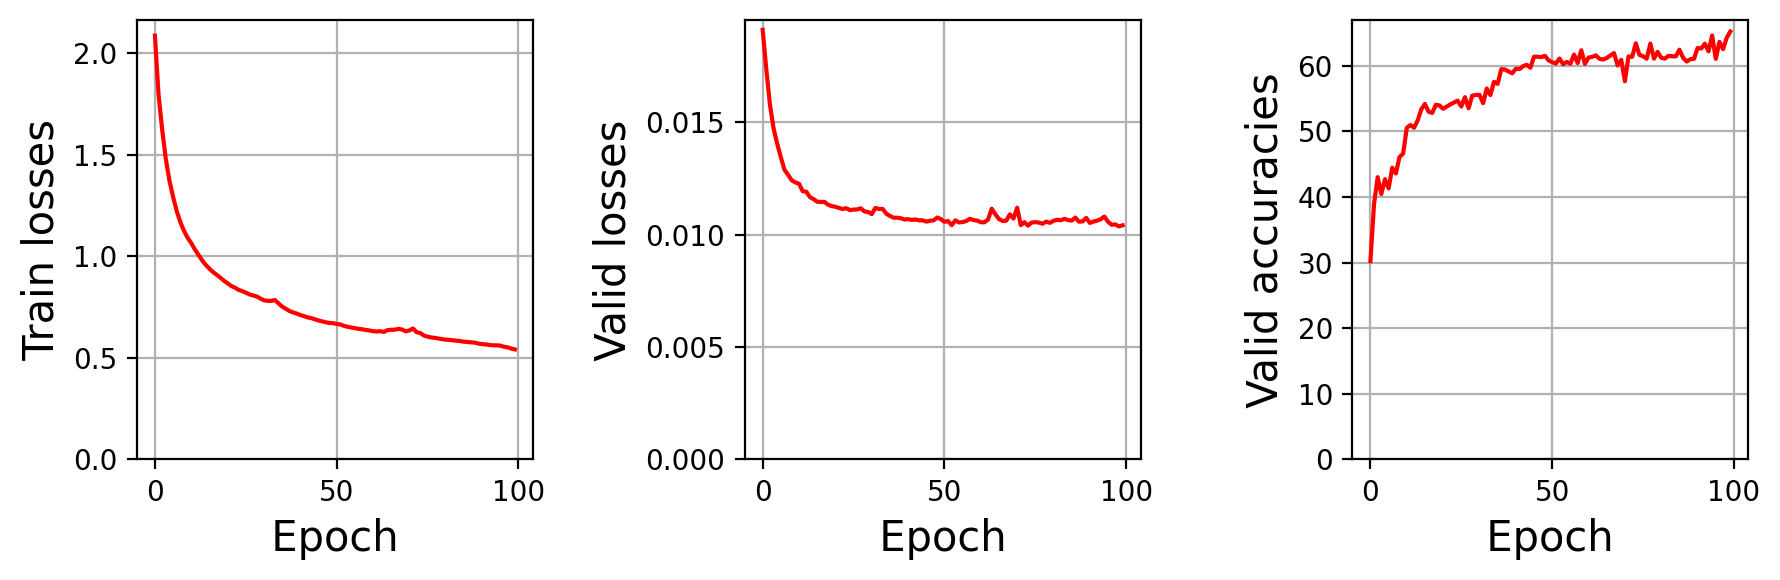

5000 data used for supervised learning
---------- Best : 87.790  at epoch  77  /  100
Run Time: 16.125783920288086	


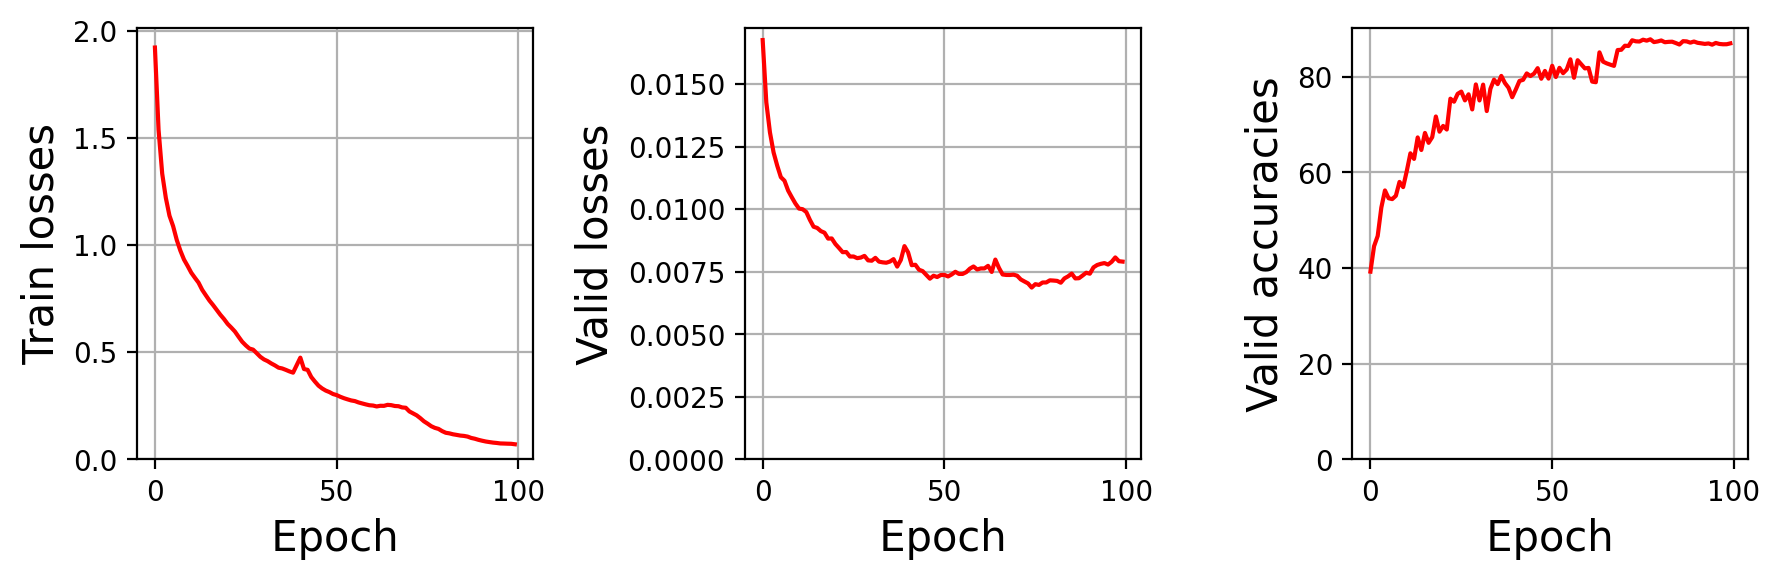

10000 data used for supervised learning
---------- Best : 92.940  at epoch  72  /  100
Run Time: 29.99874186515808	


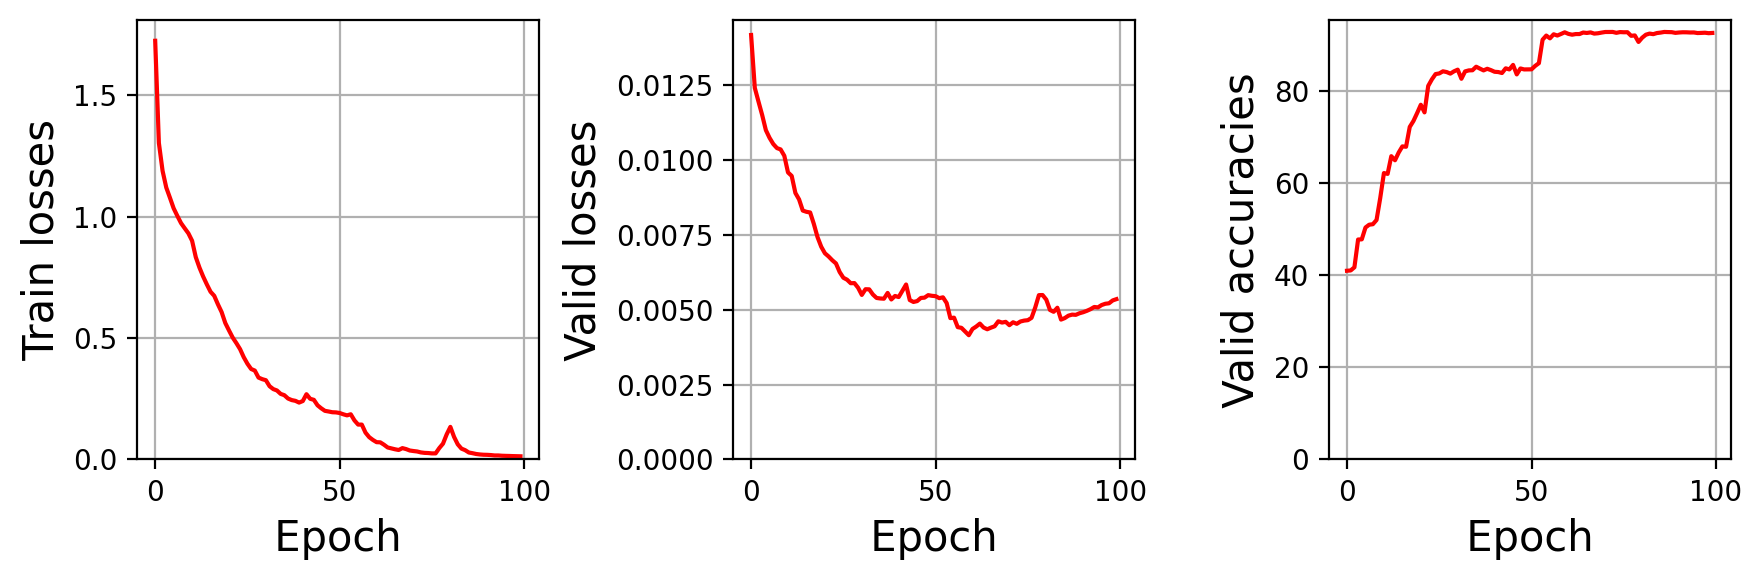

In [42]:

for i in [100, 500, 1000, 2000, 5000, 10000] :
  SemiSupervised(supervised_part = i, train_unsup = False)